# Kaggle Competition - Spaceship Titanic

*About this notebook*

The solution for the entire competition will be divided into different stages, each of them will be covered in this notebook in different sections. The structure of this notebook is the following one:

**Section 1: Problem Exploration**

This section provides a brief explanation of the "Spaceship Titanic" Kaggle Competition, including its goal, evaluation criteria, and dataset. Additionally, it covers the following matters:

- Introduction to the problem
- Datasets Overview
- Target Analysis
- Numerical Features Analysis
- Categorical Analysis

**Section 2: Data wrangling**

In this section, after understanding the data, a process of cleaning and transforming data will be applied to the datasets. Also, new features will be generated (*********************feature engineering)*********************  in this part of the notebook.  In summary, this section covers the following:

- Data transformation: Dealing with missing values, transforming columns to other types…etc
- Feature Generation

**Section 3: Model selection and Evaluation**

The focus of this section is to select the best model or models for the competition and perform hyperparameter tuning.  Last but not least, the creation of the submission file for the competition will be part of this section as well. Basically this last section is structured as follows:

- Model selection and hyperparameter tuning
- Forecasting
- Evaluation of the results

That being said, let's get started! 🤘

# Section 1: Problem Exploration

## 1-Introduction to the problem

*It is the year 2912, and we have received a transmission from four lightyears away and things aren't looking good.*

*The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.*

*While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!*

*To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.*

So, we could summarize the project as follows:

- Total number of passengers: 13K passengers (14 columns)
- **Goal**: To predict which passengers were transported by the anomaly
- **Target column**: Transported (0 = No, 1 = Yes)
- Evaluation: Accuracy (percentage of passengers correctly predicted)
- Type of problem: Binary Classification

It is important to take into account that although I will approach this problem as a binary classification I will use different models (logistic regression, random forest, neural networks, etc.) and different feature engineering techniques.

The goal is to learn and practice different techniques and to compare the results obtained with each of them.

### Datasets Overview

We are provided with three different datasets:

- **train.csv**: Training dataset with a shape of 8693 rows and 14 columns. This data will be used to train the model.
- **test.csv**: Test dataset with a shape of 4277 rows and 13 columns. This data will be used to test the model.
- **sample_submission.csv**: Sample submission file with a shape of 4277 rows and 2 columns (PassengerId and Transported). This file will be used to submit the predictions to the Kaggle competition.


As we don't have many columns, I will explain the meaning of each of them inside this notebook. All definitions are taken from the Kaggle competition, Data Dictionary section.

| Column       | Description                                                                                                 |
|--------------|-------------------------------------------------------------------------------------------------------------|
| PassengerId  | Unique identifier for each passenger. Likely to be dropped as it does not provide any useful information.  |
| Name         | Name of the passenger. It could be useful to extract the title of the passenger (Mr, Mrs, etc.) and to create a new feature. |
| CryoSleep    | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. |
| Cabin        | Cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard. |
| Destination  | The planet the passenger will be debarking to. It can be TRAPPIST-1e, 55 Cancri e, or Other.               |
| Age          | Age of the passenger. It is a continuous variable.                                                         |
| VIP          | Whether the passenger has paid for special VIP service during the voyage.                                  |
| RoomService  | Amount the passenger has billed at the Room Service amenity of Spaceship Titanic.                          |
| FoodCourt    | Amount the passenger has billed at the Food Court amenity of Spaceship Titanic.                            |
| ShoppingMall | Amount the passenger has billed at the Shopping Mall amenity of Spaceship Titanic.                         |
| Spa          | Amount the passenger has billed at the Spa amenity of Spaceship Titanic.                                   |
| VRDeck       | Amount the passenger has billed at the VR Deck amenity of Spaceship Titanic.                                |
| HomePlanet   | The planet the passenger departed from, typically their planet of permanent residence. It can be Earth, Europa, or Other. |



In [1]:
import os, sys

# Add root folder to path if not already there
root_folder = os.path.dirname(os.getcwd())
if root_folder not in sys.path: sys.path.append(root_folder)

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
sns.set_style('whitegrid')


# Own libraries and scripts 
# (exploratory data analysis)
from lib_eda.dataset_analysis import basic_eda_dataset
from lib_eda.target_analysis import basic_eda_target
from lib_eda.features_num import basic_eda_num

# (data preprocessing)
from preproc.pipelines import main_pipelines

path_kaggle_data = r'D:\Kaggle Data'
# path_kaggle_data = '/Users/juaancabsou/Documents/kaggle/data' # if macos
path_competition = 'spaceship-titanic'
path_data = path_kaggle_data + '/' + path_competition

In [2]:
# Load main datasets
train = pd.read_csv(path_data + '/' + 'train.csv')
test = pd.read_csv(path_data + '/' + 'test.csv')
sample_submission = pd.read_csv(path_data + '/' + 'sample_submission.csv')

submission_ids = test['PassengerId']

# Get target
TARGET = train['Transported']

Looking at the main stats per dataset we can see that:

- Train: Shape of 8693 rows and 14 columns | Test: Shape of 4277 rows and 13 columns
- Target: Transported (0 = No, 1 = Yes). It's completed for all the rows.
- Numerical Features:
    - Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (the ones with float64 type). Same columns for both datasets.
    - Additionally, it is worth noting that most of the numerical features, except for the "Age" feature, primarily consist of 0 values. It is important to investigate whether this distribution is accurate or requires further examination.
- Categorical Features: PassengerId, Name, CryoSleep, Cabin, Destination, VIP, HomePlanet (the ones with object type). Same columns for both datasets.
- Some missing values: HomePlanet (2.3%), CryoSleep (2.5%), Cabin (2.3%), Age (2.1%)... we will deal with them later.
- Looking at the main stats, it is expected to see some outliers in the features, we will deal with them later as well.

We must to take into account that although we will use some models such as TensorFlow Decision Forest (TFDF) that supports missing values, other models that will be used in the project require a preprocessing before feeding the data into that model. In fact, TFDF doesn’t support boolean fields with missing types so a little bit of preprocessing will be need it anyways.

In [3]:
# Create tabs widget for each dataset
datasets = ['train', 'test', 'sample_submission']
tabs = widgets.Tab()
tabs.children = [widgets.Output() for dataset in datasets]
for index, dataset in enumerate(datasets):
    tabs.set_title(index, dataset)
    with tabs.children[index]:
        basic_eda_dataset(eval(dataset), dataset)

# Create a horizontal scrollable container
scrollable_tabs = widgets.HBox([tabs], layout=widgets.Layout(overflow='auto'))

# Display the scrollable tabs
display(scrollable_tabs)

## 2.Target Analysis

Our target for this problem is to predict which passengers were transported by the anomaly. In other words, we have to predict the outcome of the "Transported" column (0 = No, 1 = Yes) for the test dataset.

So let's dive into the main characteristics of the target:

**Class Distribution**

It is important to check the distribution of the target to see if there is any class imbalance. A balanced distribution would have roughly an equal number of passengers transported and not transported. Looking at the number of values for each class, we can see that the target is **balanced**.

If there is a class imbalance, with one class dominating the other, we would have to use some techniques to deal with it (oversampling, undersampling, etc.) as this might lead to a biased model.

In such cases, evaluation metrics such as accuracy are not the best option as they might be misleading. Other metrics like precision, recall, or F1-score would be more appropriate. **In this case, we can use accuracy as the target is balanced.**

Last but not least, other evaluation metrics such as precision, recall, or F1-score, area under the ROC curve (AUC), etc. can be used to evaluate the model performance. In this case, we will use accuracy as the target is balanced.

In summary, understanding the target variable and its distribution is crucial for selecting appropriate modeling techniques and assessing model performance accurately.

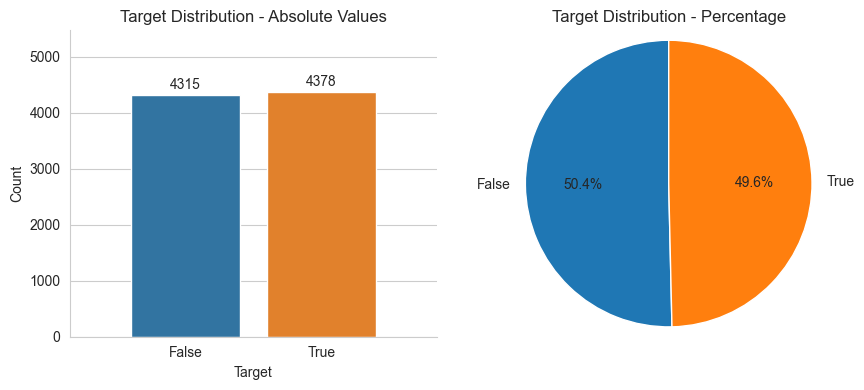

In [4]:
basic_eda_target(TARGET)

## 3.Numerical Features Analysis

The current numerical features are the following ones: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck. In this section we will perform some basic EDA with the goal of understanding the distribution of each feature and to check for outliers.

Regarding the feature *Age*:
- With a mean of 28.8 years old and a median of 27 years old, we can see that the distributions is right-skewed. This means that the mean is greater than the median and that there are some potential outliers on the right side of the distribution.
- However, the range of values is inside the expected range (0-100 years old) and there are no negative values.
- Looking the standard deviation of 14.4 years old and the median of 27 years old, we can see that the data is quite spread out. This is confirmed by the interquartile range (IQR) of 19 years old.
- We can also see that there are some outliers in the feature *Age* (passengers with more than 70 years old). However, we will not remove them as they are not extreme outliers and they could be useful for the model.


The IQR, also called the midspread, is a measure of statistical dispersion and is calculated as the difference between the upper quartile (Q3) and the lower quartile (Q1). The IQR is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR.

If we go deeper into the distribution of the feature *Age*, adding the **target** variable to the plots, we can see that:
- We can group passengers by age as it seems that there are some age ranges where the odds of being transported by the anomaly are higher.
    - For example, passengers between 0 and 10 years old have a higher probability of being transported by the anomaly.
    - On the other hand, passengers between 20 and 40 years old have a lower probability of being transported by the anomaly.
- It would be interesting to create a new feature with the age ranges and to check if it improves the model performance. In fact, we could try grouping by different age ranges and to check which one performs better.


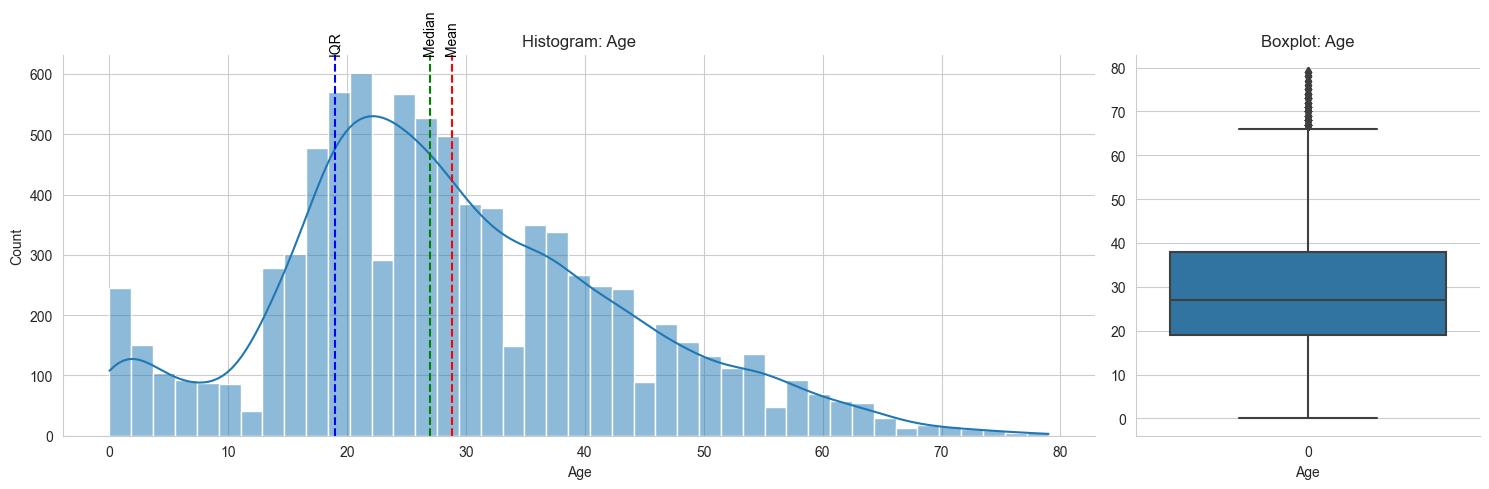

Mean: 28.82793046746535
Median: 27.0
Standard Deviation: 14.48902142390878
Minimum: 0.0
Maximum: 79.0
Range: 79.0
Interquartile Range: 19.0
-----------------------------------
Skewness: 0.42 (right)
Kurtosis: 0.10 (heavy-tailed)


In [5]:
basic_eda_num(train, 'Age', vlines_stats=True)

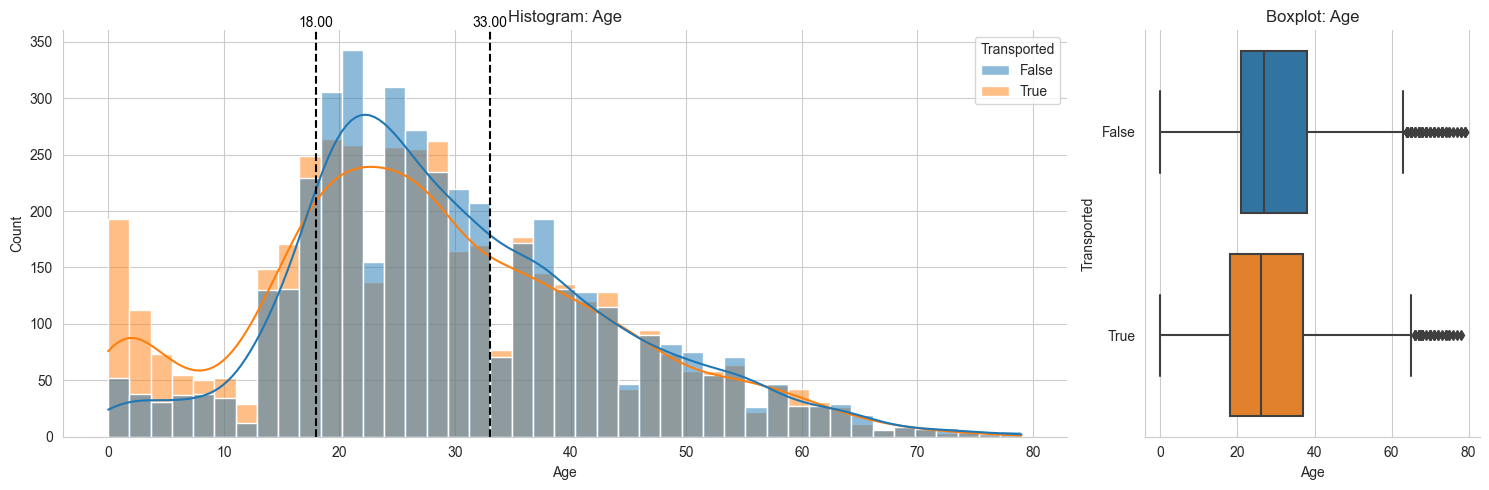

Mean: 28.82793046746535
Median: 27.0
Standard Deviation: 14.48902142390878
Minimum: 0.0
Maximum: 79.0
Range: 79.0
Interquartile Range: 19.0
-----------------------------------
Skewness: 0.42 (right)
Kurtosis: 0.10 (heavy-tailed)


In [6]:
# Create a variable for saving vertical lines to plot in the chart
vlines = [18, 33]
basic_eda_num(train, 'Age', 'Transported', vlines_stats=False, vlines_manual=vlines)

In [7]:
# Create tabs widget for each each numerical feature that is not the Age
cols_num = ['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
tabs = widgets.Tab()
tabs.children = [widgets.Output() for colNum in cols_num]
for index, colNum in enumerate(cols_num):
    tabs.set_title(index, colNum)
    with tabs.children[index]:
        basic_eda_num(train, colNum)
display(tabs)

# Section 2: Data Wrangling

Here is the summary of the different pipelines applied and generated datasets before feeding into the models. The pipeline is structured by:
- Type of variable transformed: Target - Numerical - Categorical
- And type of transformation: Missing values - Outliers - Type of value - New Feature Generated - Drop Features

The idea is to have several pipelines for generating different datasets and see which of them performs betters.


In [8]:
# Apply pipelines for preprocessing and feature engineering
df_train = main_pipelines(train, 'Transported', 'train')
df_test = main_pipelines(test, None, 'test')

Preprocessing pipeline for dataset:  train
--------------------------------------------------
Dropping column: PassengerId
Dropping column: Name
Dropping column: Cabin


Preprocessing pipeline for dataset:  test
--------------------------------------------------
Dropping column: PassengerId
Dropping column: Name
Dropping column: Cabin




# Section 3: Model Selection and evaluation

## Generate validation dataset

Before starting creating the models, we will generate a validation dataset. This dataset will be used to evaluate the performance of the models. It is important, for training and testing purposes, that we have our preprocessed data broken down into three distinct datasets.

We will use the `train_test_split` function from `sklearn` to generate the validation dataset. The idea of this is to evaluate Out of the bag (OOB) performance of the model. This is a good way to check if the model is overfitting or not. 

Basically, after the split we will have these three datasets:

- Training set: Used to train and make the model learn the hidden features or patterns in the data. This set contains **≈**67% of the original instances of the original (and preprocessed) train dataset.
- Validation set: Generated from the original training set, is used to validate the model performance during training. It is important to create and use this dataset as provides us information about if the training is moving in the right direction or not. . This set contains **≈**33% of the original instances of the original (and preprocessed) train dataset.
- Test set: In this case, it’s been given by the competition itself. It is necessary to apply the same preprocessing pipeline as the one that has been applied to training and validation set. It is used for checking the results of the model with real data.

Basically, we will train the model with the train dataset and we will evaluate the performance with the validation dataset. If the model is overfitting, the performance in the validation dataset will be lower than the performance in the train dataset

In [9]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split

# Own scripts
# from ml_scripts.tensorflow_trees import tf_tree_based_models # Just if you are in macOS/linux, and you have installed tensorflow_decision_forests
from ml_scripts.tensorflow_trees_read import * # Just if you are in windows, or you have not installed tensorflow_decision_forests

x_train, x_val, y_train, y_val = train_test_split(df_train, TARGET, test_size=0.2, random_state=42) # In this case I don't need to stratify as the target is balanced
x_train.head(1).T

## First approach: Tree Based Models with Tensorflow Decision Forest

As first approach, Tree Based Models are the best place to start for working with tabular data as these models will outperform or provide a strong baseline and help to understand the data.

There are many libraries that allow to use tree-based models, such as `scikit-learn`, `xgboost`, `lightgbm`, `catboost`, `tensorflow_decision_forests`, etc. In this case, as a first approach, `tensorflow_decision_forests` will be used. This library provides several tree-based models:

`🌳 Tree models`

- Random Forest
- Gradient Boosted Tree
- CART (Classification and Regression Tree)
- Extra Trees

Something worth to mention here is that, although a data-wrangling pipeline has been applied, the `tensorflow_decision_forests` supports empty values for numerical and categorical features but not for boolean.

In [11]:
# Get different models results using Tensorflow Decision Forests
# ----------------------------
# results of the random forest model
# results_rf = tf_tree_based_models(x_train, x_val, df_test, 'Transported', 'random_forest', hyperparameters='better_default' ) # If you want to generate the predictions
results_rf = tf_tree_based_models_read_result('random_forest') # If you want to read the predictions (faster

# results of the gradient boosted trees model
# results_gbt = tf_tree_based_models(x_train, x_val, df_test, 'Transported', 'gradient_boosted_trees', hyperparameters='better_default' ) # If you want to generate the predictions
results_gbt = tf_tree_based_models_read_result('gradient_boosted_trees') # If you want to read the predictions (faster)

# results of the cart model
# results_cart = tf_tree_based_models(x_train, x_val, df_test, 'Transported', 'cart', hyperparameters='better_default' ) # If you want to generate the predictions
results_cart = tf_tree_based_models_read_result('cart') # If you want to read the predictions (faster)

# Generate Submission Dataframe

Last step is to generate a dataframe that contains per row one column with the results of each model.

In [34]:
models_results = {
    'random_forest': results_rf,
    'gradient_boosted_trees': results_gbt,
    'cart': results_cart,
}

df_results = pd.DataFrame()
df_results_stats = pd.DataFrame()


# For df_results create column with index
df_results['PassengerId'] = submission_ids

for model_name, results in models_results.items():
    df_results[model_name] = results['predictions']
    df_results_stats[model_name] = results

print('Models statistics:')
display(df_results_stats.iloc[1:3:])

print('Models predictions:')
df_results['rf_gb_mean'] = df_results[['random_forest', 'gradient_boosted_trees']].mean(axis=1)
display(df_results.head())

Models statistics:


,random_forest,gradient_boosted_trees,cart
loss,0.0,0.0,0.0
accuracy,0.795285,0.795285,0.749281


Models predictions:


,PassengerId,random_forest,gradient_boosted_trees,cart,rf_gb_mean
0,0013_01,0.786666,0.784441,0.820225,0.785553
1,0018_01,0.003333,0.042055,0.019139,0.022694
2,0019_01,0.996666,0.982632,0.986152,0.989649
3,0021_01,0.936666,0.985128,0.742331,0.960897
4,0023_01,0.500000,0.645528,0.601961,0.572764


In [22]:
import subprocess

submit_to_kaggle = False
if submit_to_kaggle:
    PATH_SUBMISSION = 'C:/Users/juaan/Documents/GitHub/kaggle/kaggle_spaceship/y_forecast/'
    COLUMN_RESULT = 'rf_gb_mean'
    SUBMISSION_FILE = PATH_SUBMISSION + 'submission_' + COLUMN_RESULT + '.csv' # This file will be the one that will be submitted to Kaggle using the API

    # Generate the submission file
    # ----------------------------

    df_submission_final = df_results[['PassengerId', COLUMN_RESULT]].copy()
    # In this case as I need to submit the result as True or False, I need to round the result and convert it to boolean
    df_submission_final[COLUMN_RESULT] = df_submission_final[COLUMN_RESULT].apply(lambda x: True if x >= 0.5 else False)
    df_submission_final.rename(columns={COLUMN_RESULT: 'Transported'}, inplace=True)
    df_submission_final.to_csv(SUBMISSION_FILE, index=False)

    # Submit the file to Kaggle
    # --------------------------
    command = f"kaggle competitions submit -c spaceship-titanic -f {SUBMISSION_FILE} -m \"Submission {COLUMN_RESULT}\""

    # Execute the command using subprocess
    try:
        subprocess.run(command, shell=True, check=True)
        print("Submission successful!")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e}")


Submission successful!
